# llc4320 drifters spectra

- trajectory should be an integer

- can you output velocity directly from parcels ?

- Need to append water depth to dataframe
- Need to check time sampling


In [1]:
import os
#from glob import glob

import numpy as np
import pandas as pd
import xarray as xr

from scipy import signal

import geopandas as gpd
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
from shapely import wkt
from shapely.geometry import Polygon

from dask.delayed import delayed
import dask.dataframe as dd

%matplotlib inline
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

import mitequinox.utils as ut
import mitequinox.parcels as pa
import mitequinox.drifters as dr

In [2]:
if True:
    from dask.distributed import Client, LocalCluster
    from dask_jobqueue import PBSCluster
    #cluster = PBSCluster()
    cluster = PBSCluster(cores=28, processes=14)
    w = cluster.scale(jobs=4)
    #
    client = Client(cluster)
    client
else:
    from dask.distributed import Client, LocalCluster
    #
    cluster = LocalCluster()
    client = Client(cluster)
    client

In [3]:
client

Client Scheduler: tcp://10.148.0.57:50507 Dashboard: http://10.148.0.57:8787/status,Cluster Workers: 0 Cores: 0 Memory: 0 B


---
## load data

In [130]:
#root_dir = '/home1/scratch/aponte/parcels/'
#root_dir = '/home1/dunree/slgentil/tmp/parcels/'
root_dir = '/home1/datawork/slgentil/parcels/'

run_name = 'global_T365j_dt1j_dij50'

run_dir = root_dir+run_name
run_dir_tmp = '/home1/datawork/aponte/tmp/' # !!! tmp

#df = pa.load_cdf(run_dir, index='time', persist=True)
df = dd.read_parquet(run_dir_tmp+'drifters/trajectory')

In [160]:
run_dir_tmp+'drifters/diagnostics'

'/home1/datawork/aponte/tmp/drifters/trajectory'

In [131]:
# add time in seconds
df = df.rename(columns={'time': 'date'})
t_start = df.date.min().compute()
df['time'] = (df['date'] - t_start)/pd.Timedelta('1D')

In [132]:
df.head()

,date,lat,lon,z,time
trajectory,,,,,
4000000.0,2011-11-15,41.797028,-34.864582,0.0,0.0
4000001.0,2011-11-15,42.514122,-34.864582,0.0,0.0
4000002.0,2011-11-15,43.223770,-34.864582,0.0,0.0
4000003.0,2011-11-15,43.925968,-34.864582,0.0,0.0
4000004.0,2011-11-15,44.620720,-34.864582,0.0,0.0


In [133]:
# Should check time sampling

In [134]:
df = df.persist()

---

## start processing

In [156]:
def process_window(lon, lat, N, dt, **kwargs):
    ''' Wraps spectral calculation: add complex velocity
    Assumes the time series is regularly sampled
    '''
    if lon is None:
        uv = None
    else:
        # compute displacements
        lon1, lat1 = lon.shift(periods=-1), lat.shift(periods=-1)
        u = dr.haversine(lon, lat, lon1, lat)*1e3 *np.sign(lon1-lon) /dt
        v = dr.haversine(lon, lat, lon, lat1)*1e3 *np.sign(lat1-lat) /dt
        u = pd.Series(u, index=lon.index).fillna(method='ffill')
        v = pd.Series(v, index=lon.index).fillna(method='ffill')
        uv = (u + 1j*v)
    return dr.get_spectrum(uv, N, dt=dt, **kwargs)

In [157]:
T = 20
dt=1/24
N = int(T/dt)+1

df_chunked = (df.reset_index() # don't understand why reset_index is required here
              .groupby('trajectory')
              .apply(time_window_processing,
                     process_window,
                     ['lon', 'lat'],
                     T, 
                     N,
                     id_label='trajectory',
                     dt=1/24.,
                    )
              .persist()
             )

<ipython-input-157-183c96585f2d>:5: UserWarning: `meta` is not specified, inferred from partial data. Please provide `meta` if the result is unexpected.
  Before: .apply(func)
  After:  .apply(func, meta={'x': 'f8', 'y': 'f8'}) for dataframe result
  or:     .apply(func, meta=('x', 'f8'))            for series result
  df_chunked = (df.reset_index() # don't understand why reset_index is required here


In [158]:
# the dataframe partitions has a multi-index: id and window central time (unknow name for now)
# we first transform the index corresponding to time into a regular column.
df_chunked = (
              df_chunked.map_partitions(
                  lambda df: df.reset_index(level=[1]).rename(columns={'level_1': 'time'})
                                       )
              )
df_chunked.head()

,time,lon,lat,id,0.0,0.0498960498960499,0.0997920997920998,0.1496881496881497,0.1995841995841996,0.2494802494802495,...,-0.498960498960499,-0.4490644490644491,-0.3991683991683992,-0.3492723492723493,-0.2993762993762994,-0.2494802494802495,-0.1995841995841996,-0.1496881496881497,-0.0997920997920998,-0.0498960498960499
trajectory,,,,,,,,,,,,,,,,,,,,,
1000038.0,10.0,-35.426892,-53.603172,1000038.0,8.191388e+07,1.486971e+08,4.234977e+07,2.308854e+08,2.482435e+08,4.418586e+07,...,4.062837e+05,5.259524e+06,2.104528e+07,6.143945e+06,3.224063e+07,9.282402e+07,1.171633e+08,6.476126e+07,2.378920e+08,4.861240e+08
1000038.0,20.0,-35.107080,-53.341913,1000038.0,6.598177e+08,1.961778e+09,1.214519e+09,2.947228e+08,5.965954e+08,1.581360e+08,...,1.030062e+06,6.269167e+05,4.378213e+06,2.099389e+07,4.890954e+07,9.581410e+07,5.655565e+06,4.051941e+08,2.321530e+08,2.906489e+07
1000038.0,30.0,-34.439479,-52.764718,1000038.0,1.386807e+09,2.220644e+08,1.301470e+08,8.072302e+07,2.204010e+07,3.795455e+05,...,1.289621e+06,1.975037e+06,5.681016e+06,3.496665e+07,6.586404e+07,6.836227e+07,7.759046e+07,1.261325e+08,2.575891e+08,1.482544e+09
1000038.0,40.0,-32.864209,-52.050459,1000038.0,4.185146e+09,2.946849e+09,3.541449e+08,1.109330e+08,1.685510e+08,5.649342e+07,...,9.705363e+06,2.510829e+06,1.501092e+07,6.494538e+07,9.835021e+07,2.287662e+07,3.429228e+07,1.618287e+08,1.027017e+09,3.531500e+08
1000038.0,50.0,-31.272577,-51.375837,1000038.0,1.070090e+09,6.113175e+07,2.865508e+08,1.325803e+08,5.208708e+07,6.615406e+07,...,3.319501e+07,3.148699e+07,1.138319e+07,1.304889e+07,5.841949e+07,2.336145e+07,8.656588e+07,4.507291e+07,5.379054e+08,1.232214e+08


In [159]:
# store to parquet
pa.store_parquet()

Signature:
pa.store_parquet(
    run_dir,
    df,
    partition_size='100MB',
    index='trajectory',
    overwrite=False,
    engine='auto',
    compression='ZSTD',
)
Docstring:
store data under parquet format

Parameters
----------
run_dir: str, path to the simulation
df: dask dataframe to store
partition_size: str, optional
    size of each partition that will be enforced
    Default is '100MB' which is dask recommended size
index: str, which index to set before storing the dataframe
overwrite: bool, can overwrite or not an existing archive
engine: str, engine to store the parquet format
compression: str, type of compression to use when storing in parquet format
File:      ~/mit_equinox/mitequinox/parcels.py
Type:      function


In [ ]:
# read parquet file

In [ ]:
# bin geographically
lat_bins = np.arange(-60, 60, 1.)
lat_idx = pd.IntervalIndex.from_breaks(lat_bins)
df_chunked['lat_cut'] = df_chunked['lat'].map_partitions(pd.cut, bins=lat_bins)

E = df_chunked.groupby(['lat_cut']).mean().compute()

#Converting pandas dataframe in xarray dataset:
ds = (pd.melt(E.set_index(E.index.map(lambda v: v.mid))
              .drop(columns=['id','time','lon','lat'])
              .reset_index(), id_vars=['lat_cut',], var_name='frequency')
              .rename(columns={'lat_cut': 'lat_bins', 'value': 'E'})
     ).to_xarray().set_index(index=['lat_bins','frequency']).unstack()

In [ ]:
np.log10(ds.E).plot()

--- 

## dev

In [136]:
_df = df.groupby(df.index).get_group(4000003.).compute()
_df

,date,lat,lon,z,time
trajectory,,,,,
4000003.0,2011-11-15 00:00:00,43.925968,-34.864582,0.0,0.000000
4000003.0,2011-11-15 01:00:00,43.913090,-34.859255,0.0,0.041667
4000003.0,2011-11-15 02:00:00,43.900373,-34.857987,0.0,0.083333
4000003.0,2011-11-15 03:00:00,43.889137,-34.858245,0.0,0.125000
4000003.0,2011-11-15 04:00:00,43.879369,-34.859307,0.0,0.166667
...,...,...,...,...,...
4000003.0,2012-11-13 21:00:00,43.803438,-2.490262,0.0,364.875000
4000003.0,2012-11-13 22:00:00,43.809948,-2.493495,0.0,364.916667
4000003.0,2012-11-13 23:00:00,43.815541,-2.493457,0.0,364.958333


In [140]:
T = 20
dt=1/24
N = int(T/dt)+1

df_out = time_window_processing(_df, 
                             process_window, 
                             ['lon', 'lat'], 
                             T, 
                             N, 
                             id_label='trajectory',
                             dt=1/24.,
                            )

/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home1/datahome/aponte/.miniconda3/envs/equinox/lib/python3.8/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)
<ipython-input-139-b3fd3363cd2a>:147: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and da

In [141]:
df_out

,lon,lat,id,0.0,0.0498960498960499,0.0997920997920998,0.1496881496881497,0.1995841995841996,0.2494802494802495,0.2993762993762994,...,-0.498960498960499,-0.4490644490644491,-0.3991683991683992,-0.3492723492723493,-0.2993762993762994,-0.2494802494802495,-0.1995841995841996,-0.1496881496881497,-0.0997920997920998,-0.0498960498960499
10.0,-33.987647,44.210535,4000003.0,3.201861e+09,9.786165e+08,7.069268e+08,4.445527e+08,9.583613e+07,1.305268e+08,1.244281e+08,...,1.317285e+08,9.529313e+07,3.206281e+07,4.429907e+07,1.366397e+08,1.066257e+08,3.338880e+07,1.227857e+08,8.779006e+08,3.052464e+09
20.0,-33.015810,44.714011,4000003.0,2.879357e+09,3.684784e+08,1.117619e+09,7.474890e+08,2.153984e+08,2.079744e+06,5.603076e+07,...,2.532811e+07,2.827107e+07,5.785613e+07,5.259986e+06,3.675500e+07,1.360945e+08,2.322913e+08,1.263168e+09,1.256947e+09,5.018741e+09
30.0,-30.857709,44.285476,4000003.0,6.556715e+09,5.347575e+09,1.222066e+08,2.022573e+08,2.223466e+08,7.336854e+07,2.364630e+07,...,1.025470e+08,4.934693e+07,6.363050e+07,8.640102e+07,3.390014e+07,6.428824e+07,4.544856e+08,4.304694e+08,5.319276e+08,1.221332e+09


### define bins

In [148]:
# geographical bins
dl = 2.
lon_bins = np.arange(-180.,180., dl)
lat_bins = np.arange(-90.,90., dl)

#lon_idx = pd.IntervalIndex.from_breaks(lon_bins)
#lat_idx = pd.IntervalIndex.from_breaks(lat_bins)

# temporal bins
#t_bins = pd.date_range(t_start, t_end, freq='1M')
t_bins = pd.date_range(t_start, t_end, freq='1MS') # starts at the beginning of each month
cut = lambda df, bins: pd.cut(df.index.to_series(), bins=bins)

In [149]:
df['lon'] = (df['lon']+180)%360 - 180
df['lon_cut'] = df['lon'].map_partitions(pd.cut, lon_bins)
df['lat_cut'] = df['lat'].map_partitions(pd.cut, lat_bins)
cut = lambda df, bins: pd.cut(df.index.to_series(), bins=bins)
df['time_cut'] = df.map_partitions(cut, t_bins)

In [150]:
df = df.persist()

### group by geographical area

In [166]:
def add_geodata(df):

    df['lon'] = df.apply(lambda r: r.name[0].mid, axis=1)
    df['lat'] = df.apply(lambda r: r.name[1].mid, axis=1)

    def area(r):
        lon0, lon1 = r.name[0].left, r.name[0].right
        lat0, lat1 = r.name[1].left, r.name[1].right
        return Polygon([[lon0, lat0],[lon1, lat0], [lon1, lat1], [lon0, lat1]])

    df['Coordinates'] = df.apply(area, axis=1)
    df = gpd.GeoDataFrame(df, geometry='Coordinates', crs='EPSG:4326')
    df['area'] = df.to_crs(crs = 'epsg:3857').area /1e6 / 1e4 # 100km^2 units
    
    return df

In [167]:
count = (df
         .groupby([df.lon_cut, df.lat_cut])
         .count()
         .compute()
         ['z'].rename('count')
         .to_frame()
        )

# normalize by time window length
count = count/delta_t
#
count = add_geodata(count)
count['density'] = count['count']/count['area']

ds = (count
      .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat'])
      .to_xarray()
     )

Text(0.5, 1.0, 'Average number of floats per 100km^2 and per day')

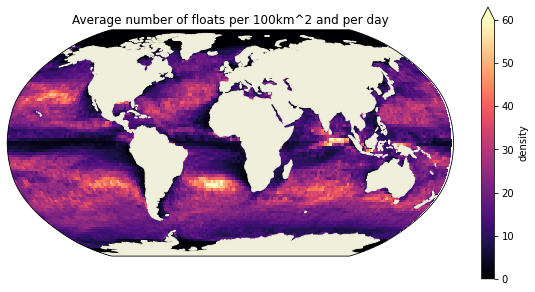

In [170]:
figsize = (10,5)

#crs = ccrs.Mollweide()
crs = ccrs.Robinson()
#crs = ccrs.EqualEarth()
#crs = ccrs.Geodetic()

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=crs)

ds['density'].plot(x='lon', 
                 y='lat',
                 vmax=60,
                 cmap='magma',
                 ax=ax,
                 transform=ccrs.PlateCarree(),
                )

#ax.add_feature(cfeature.LAND.with_scale('110m'))
ax.add_feature(cfeature.LAND, zorder=1)

ax.set_title('Average number of floats per 100km^2 and per day')

---
## group by month

In [161]:
count = (df
         .groupby('time_cut')
         .count()['z']
         .compute()
         .rename('count')
         .to_frame()
        )
count['time'] = count.index.to_series().apply(lambda d: d.left)

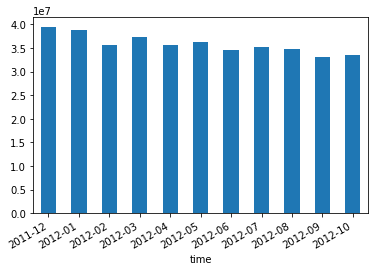

In [162]:
fig, ax = plt.subplots()
count['time'] = count.index.to_series().apply(lambda d: d.left)
count.set_index('time')['count'].plot.bar(ax=ax)
ax.set_xticklabels([pd.Timestamp(t.get_text()).strftime('%Y-%m') for t in ax.get_xticklabels()])
fig.autofmt_xdate()

---
### group by geographical area and month

In [169]:
count = (df
         .groupby([df.lon_cut, df.lat_cut, df.time_cut])
         .count()['z']
         .compute()
         .rename('count')
         .to_frame()
        )
count = count/30 # normalize per number of days

count['time'] = count.index.to_series().apply(lambda v: v[2].left)

count = add_geodata(count)

ds = (count
      .drop(columns=['Coordinates'])
      .set_index(['lon', 'lat', 'time'])
      .to_xarray()
     )

ds['density'] = ds['count']/ds['area']

count       time
lon_cut          lat_cut        time_cut                                  
(-180.0, -178.0] (-90.0, -88.0] (2011-12-01, 2012-01-01]    0.0 2011-12-01
                                (2012-01-01, 2012-02-01]    0.0 2012-01-01
                                (2012-02-01, 2012-03-01]    0.0 2012-02-01
                                (2012-03-01, 2012-04-01]    0.0 2012-03-01
                                (2012-04-01, 2012-05-01]    0.0 2012-04-01
...                                                         ...        ...
(176.0, 178.0]   (86.0, 88.0]   (2012-06-01, 2012-07-01]    0.0 2012-06-01
                                (2012-07-01, 2012-08-01]    0.0 2012-07-01
                                (2012-08-01, 2012-09-01]    0.0 2012-08-01
                                (2012-09-01, 2012-10-01]    0.0 2012-09-01
                                (2012-10-01, 2012-11-01]    0.0 2012-10-01

[175241 rows x 2 columns]

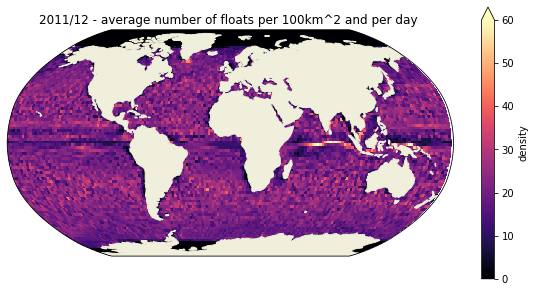

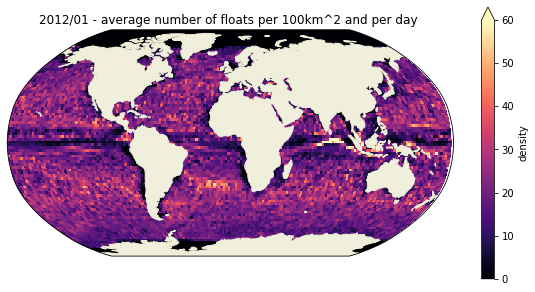

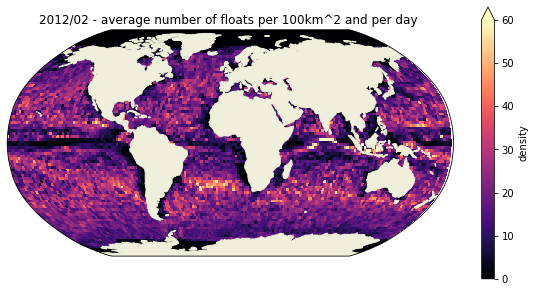

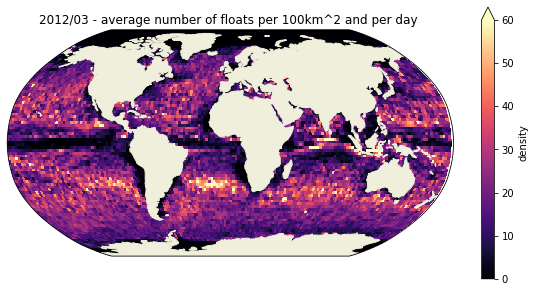

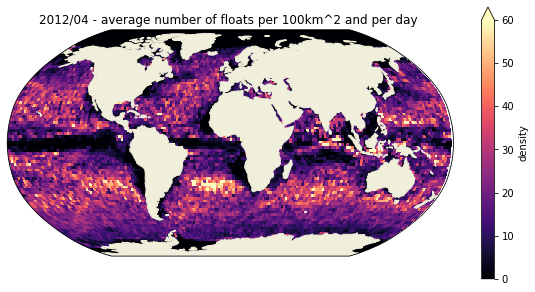

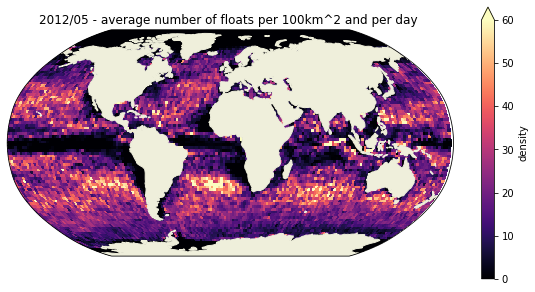

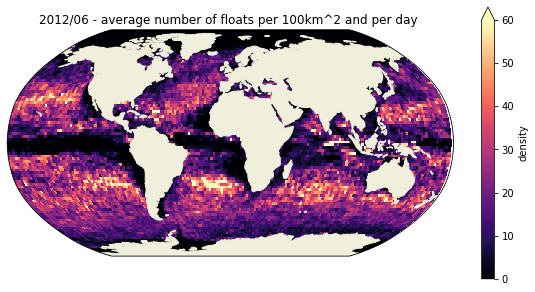

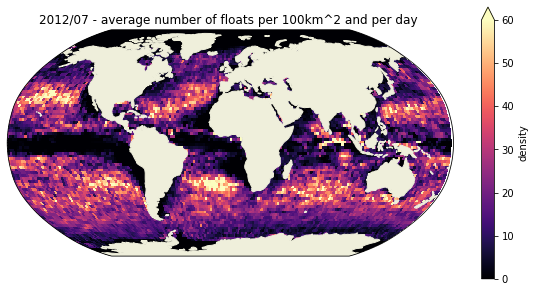

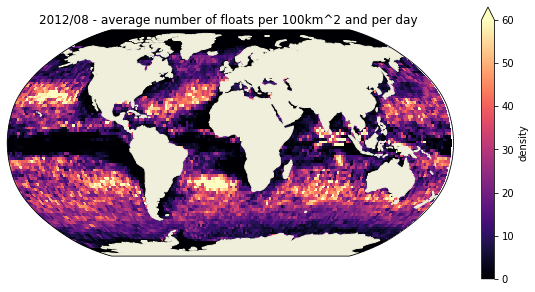

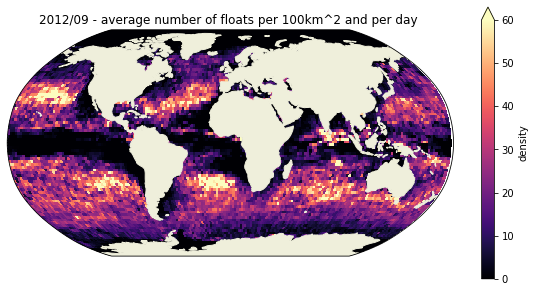

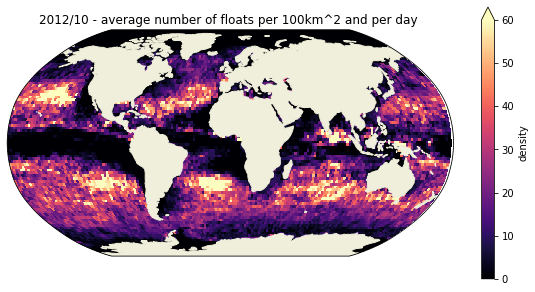

In [198]:
figsize = (10,5)

for t in ds.time:
    
    _ds = ds.sel(time=t)
    
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection=crs)

    _ds['density'].plot(x='lon', 
                     y='lat',
                     vmax=60,
                     cmap='magma',
                     ax=ax,
                     transform=ccrs.PlateCarree(),
                    )

    #ax.add_feature(cfeature.LAND.with_scale('110m'))
    ax.add_feature(cfeature.LAND, zorder=1)

    ax.set_title('{} - average number of floats per 100km^2 and per day '.format(t.dt.strftime('%Y/%m').values))

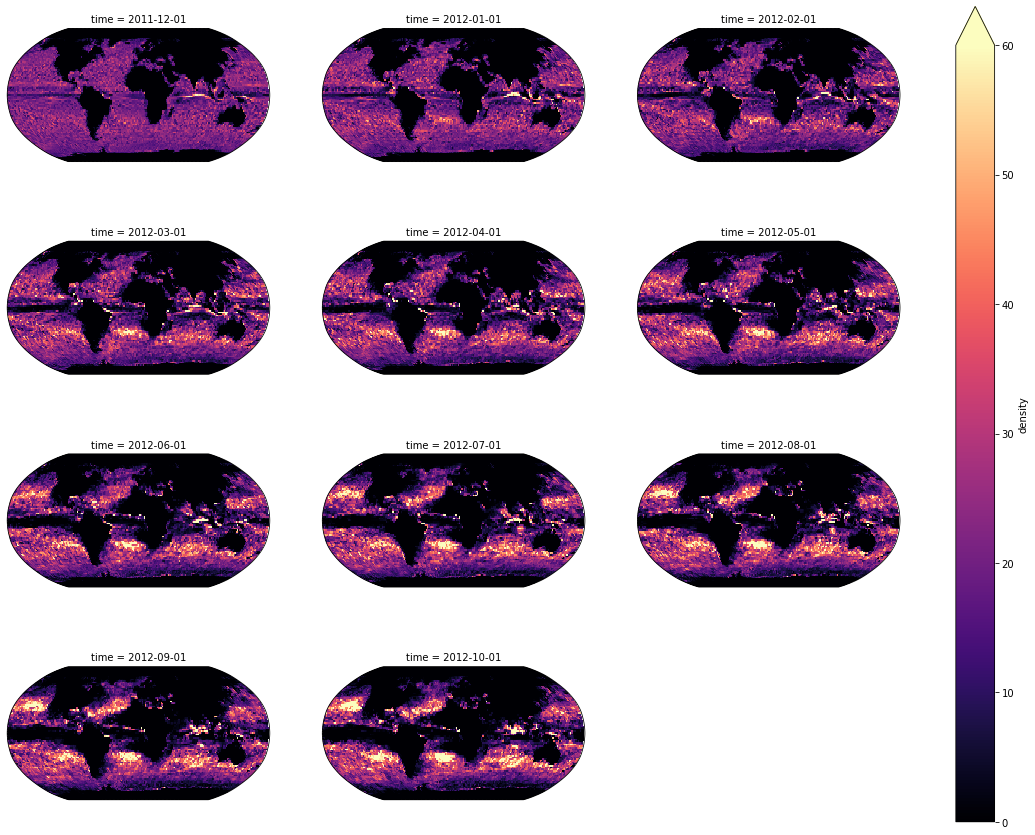

In [185]:
# land cannot be shown ...
ds['density'].plot(x='lon', 
                   y='lat',
                   col='time',
                   col_wrap=3,
                   vmax=60,
                   cmap='magma',
                   transform=ccrs.PlateCarree(),
                   subplot_kws={'projection':crs},
                   figsize=(20,15),
                  )

In [199]:
ds

<xarray.Dataset>
Dimensions:  (lat: 89, lon: 179, time: 11)
Coordinates:
  * lon      (lon) float64 -179.0 -177.0 -175.0 -173.0 ... 173.0 175.0 177.0
  * lat      (lat) float64 -89.0 -87.0 -85.0 -83.0 -81.0 ... 81.0 83.0 85.0 87.0
  * time     (time) datetime64[ns] 2011-12-01 2012-01-01 ... 2012-10-01
Data variables:
    count    (lon, lat, time) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    area     (lon, lat, time) float64 nan nan nan nan ... 98.47 98.47 98.47
    density  (lon, lat, time) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0

Text(0.5, 1.0, 'Average number of floats per 100km^2 and per day')

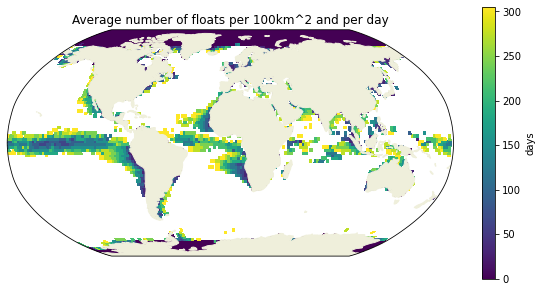

In [207]:
day_no_float = (ds.density.where(ds.density==0).idxmax('time') - ds.time.min()).dt.days

figsize = (10,5)

fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection=crs)

day_no_float.plot(x='lon', 
                 y='lat',
                 cmap='viridis',
                 ax=ax,
                 transform=ccrs.PlateCarree(),
                )

#ax.add_feature(cfeature.LAND.with_scale('110m'))
ax.add_feature(cfeature.LAND, zorder=1)

ax.set_title('First time without float in {}deg x {}deg boxes'.format(dl,dl))

## Close cluster

In [50]:
cluster.close()